# Creating a binary classifier to detect smiles

In [ ]:
import os
import pathlib
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *

In [ ]:
def load_images_and_labels(image_paths):
    images = []
    labels = []

    for image_path in image_paths:
        image = load_img(image_path, target_size=(32, 32),
                         color_mode='grayscale')
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]
        label = 'positive' in label
        label = float(label)

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
def build_network():
    input_layer = Input(shape=(32, 32, 1))
    x = Conv2D(filters=20,
               kernel_size=(5, 5),
               padding='same',
               strides=(1, 1))(input_layer)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),
                     strides=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(filters=50,
               kernel_size=(5, 5),
               padding='same',
               strides=(1, 1))(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),
                     strides=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(units=500)(x)
    x = ELU()(x)
    x = Dropout(0.4)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
cd ..

/


## Downloading the dataset and creating X and Y labels

In [ ]:
#download the dataset which is hosted in the following repo.
if not os.path.isdir("SMILEsmileD"):
    !git clone https://github.com/hromi/SMILEsmileD.git

Cloning into 'SMILEsmileD'...
remote: Enumerating objects: 13190, done.
remote: Total 13190 (delta 0), reused 0 (delta 0), pack-reused 13190
Receiving objects: 100% (13190/13190), 37.48 MiB | 29.89 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
files_pattern = "SMILEsmileD/SMILEs/*/*/*.jpg"

dataset_paths = [*glob.glob(files_pattern)]
print("the dataset paths:> ",dataset_paths)

the dataset paths:>  ['SMILEsmileD/SMILEs/negatives/negatives7/490.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/12707.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/9798.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/10804.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/2385.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/13197.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/2459.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/1535.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/7113.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/12145.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/10023.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/11957.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/7022.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/1337.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/11543.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/8876.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/4323.jpg', 'SMILEsmileD/SMILEs/negatives/negatives7/5466.jpg', 'SMILEsmileD/SMILEs/negatives/negati

In [ ]:
X, y = load_images_and_labels(dataset_paths)

In [ ]:
X /= 255.0
total = len(y)
total_positive = np.sum(y)
total_negative = total - total_positive
print(f'Total images: {total}')
print(f'Smile images: {total_positive}')
print(f'Non-smile images: {total_negative}')

Total images: 13165
Smile images: 3690.0
Non-smile images: 9475.0


## Splitting X_train and X_test 

In [ ]:
(X_train, X_test,y_train, y_test) = train_test_split(X, y,
                                     test_size=0.2,
                                     stratify=y,
                                     random_state=999)

## Again from X_train split for X_val

In [ ]:
(X_train, X_val,
 y_train, y_val) = train_test_split(X_train, y_train,
                                    test_size=0.2,
                                    stratify=y_train,
                                    random_state=999)

In [ ]:
model = build_network()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          class_weight={
              1.0: total / total_positive,
              0.0: total / total_negative
          })
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {test_loss}, accuracy: {test_accuracy}')

Epoch 1/20
264/264 [==============================] - 17s 14ms/step - loss: 1.9583 - accuracy: 0.7447 - val_loss: 3.3539 - val_accuracy: 0.3844
Epoch 2/20
264/264 [==============================] - 3s 12ms/step - loss: 0.9517 - accuracy: 0.8262 - val_loss: 0.3250 - val_accuracy: 0.8823
Epoch 3/20
264/264 [==============================] - 3s 12ms/step - loss: 0.8327 - accuracy: 0.8445 - val_loss: 0.4442 - val_accuracy: 0.8771
Epoch 4/20
264/264 [==============================] - 3s 12ms/step - loss: 0.7367 - accuracy: 0.8607 - val_loss: 0.4491 - val_accuracy: 0.8719
Epoch 5/20
264/264 [==============================] - 3s 13ms/step - loss: 0.6726 - accuracy: 0.8679 - val_loss: 0.2858 - val_accuracy: 0.8942
Epoch 6/20
264/264 [==============================] - 3s 13ms/step - loss: 0.6122 - accuracy: 0.8804 - val_loss: 0.3772 - val_accuracy: 0.8889
Epoch 7/20
264/264 [==============================] - 3s 12ms/step - loss: 0.5764 - accuracy: 0.8916 - val_loss: 0.2555 - val_accuracy: 0.900

## Testing the model on unseen data from internet

In [ ]:
!wget -O test_img.jpg --no-check-certificate "https://image.freepik.com/free-photo/close-up-happy-face-boy_1150-12122.jpg"

--2022-01-22 12:11:48--  https://image.freepik.com/free-photo/close-up-happy-face-boy_1150-12122.jpg
Resolving image.freepik.com (image.freepik.com)... 184.51.221.135, 2600:1407:3c00:1088::30ec, 2600:1407:3c00:10a1::30ec
Connecting to image.freepik.com (image.freepik.com)|184.51.221.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55401 (54K) [image/jpeg]
Saving to: ‘test_img.jpg’

test_img.jpg        100%[===================>]  54.10K  --.-KB/s    in 0.01s   

2022-01-22 12:11:49 (3.74 MB/s) - ‘test_img.jpg’ saved [55401/55401]



In [ ]:
!wget -O test_img2.jpg --no-check-certificate "https://cdn.hswstatic.com/gif/smiling-makes-you-happy-1.jpg"

--2022-01-22 12:18:48--  https://cdn.hswstatic.com/gif/smiling-makes-you-happy-1.jpg
Resolving cdn.hswstatic.com (cdn.hswstatic.com)... 99.84.160.37, 99.84.160.55, 99.84.160.89, ...
Connecting to cdn.hswstatic.com (cdn.hswstatic.com)|99.84.160.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20186 (20K) [image/jpeg]
Saving to: ‘test_img2.jpg’

test_img2.jpg       100%[===================>]  19.71K  --.-KB/s    in 0.01s   

2022-01-22 12:18:48 (1.79 MB/s) - ‘test_img2.jpg’ saved [20186/20186]



In [ ]:
image = load_img("SMILEsmileD/SMILEs/negatives/negatives7/490.jpg", target_size=(32, 32),
                         color_mode='grayscale')
image = img_to_array(image)
image= image/255.0

In [ ]:
image = np.expand_dims(image, axis=0)

In [ ]:
model.predict(image) #if the value is below 0.5 then its negative sample and visa-versa, its positive

array([[0.07119087]], dtype=float32)

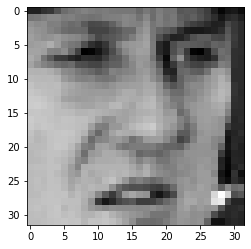

In [ ]:
import matplotlib.pyplot as plt
image = load_img("SMILEsmileD/SMILEs/negatives/negatives7/490.jpg", target_size=(32, 32),
                         color_mode='grayscale')
plt.imshow(image,cmap='gray')